# Inference and Diagnostics

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
import arviz as az
from jax import random
import jax.numpy as jnp

In [82]:
rng_key = random.key(0)

In [83]:
DATA_PATH = "../data/msn_arrivals.csv"
msn_arrivals = pd.read_csv(DATA_PATH)

Recall, we are using 2 models to model the arrival delays


**Model 1**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\sigma &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \mathcal{N}(\mu, \sigma)
\end{aligned}
$$

**Model 2**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\beta &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \text{Gumbel}(\mu, \beta)\\
\end{aligned}
$$

In [84]:
class HalfStudentT(dist.Distribution):
    arg_constraints = {
        "df": dist.constraints.positive,
        "scale": dist.constraints.positive,
    }
    support = dist.constraints.positive
    reparametrized_params = ["df", "scale"]
    pytree_data_fields = ("df", "scale", "_chi2")

    def __init__(self, df, scale=1.0, *, validate_args=None):
        from jax import lax
        self._studentT = dist.StudentT(df, 0.0, scale)
        batch_shape = lax.broadcast_shapes(
            jnp.shape(df), jnp.shape(scale)
        )
        self.df, self.scale = numpyro.distributions.util.promote_shapes(
            df, scale, shape=batch_shape
        )
        df = jnp.broadcast_to(df, batch_shape)
        self._chi2 = dist.Chi2(df)
        super(HalfStudentT, self).__init__(batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        return jnp.abs(self._studentT.sample(key, sample_shape))
    
    @numpyro.distributions.util.validate_sample
    def log_prob(self, value):
        return self._studentT.log_prob(value) + jnp.log(2)

In [188]:
def model1(delay_obs=None, size=1):
    if delay_obs is not None:
        size = len(delay_obs)
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    sigma = numpyro.sample("sigma", HalfStudentT(5, 60))
    return numpyro.sample("delay", dist.Normal(mu, sigma), obs=delay_obs, sample_shape=(size,))

In [189]:
def model2(delay_obs=None, size=1):
    if delay_obs is not None:
        size = len(delay_obs)
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    beta = numpyro.sample("beta", HalfStudentT(5, 60))
    return numpyro.sample("delay", dist.Gumbel(mu, beta), obs=delay_obs, sample_shape=(size,))

In [190]:
def sample(model, rng_key_, delays):
    rng_key_, rng_key__ = random.split(rng_key_)
    rng_key_prior, rng_key_posterior = random.split(rng_key_)
    kernel = NUTS(model)
    sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
    sampler.run(rng_key__, delays)
    prior_predictive_samples = Predictive(model, num_samples=1000)(rng_key_prior, size=len(delays))
    posterior_predictive_samples = Predictive(model, sampler.get_samples())(rng_key_posterior, size=len(delays))
    return az.from_numpyro(sampler, prior=prior_predictive_samples, posterior_predictive=posterior_predictive_samples)

## Inference

In [191]:
delays = jnp.array(msn_arrivals.values)

In [192]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model1 = sample(model1, rng_key_, delays)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_27316\2120246503.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3351.46it/s, 3 steps of size 7.35e-01. acc. prob=0.94]


In [193]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model2 = sample(model2, rng_key_, delays)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_27316\2120246503.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3291.54it/s, 3 steps of size 8.92e-01. acc. prob=0.89]


## Diagnostics

We evaluate the run by checking the trace and rank plots

Rank plot of the posterior samples from the model with Normal likelihood.

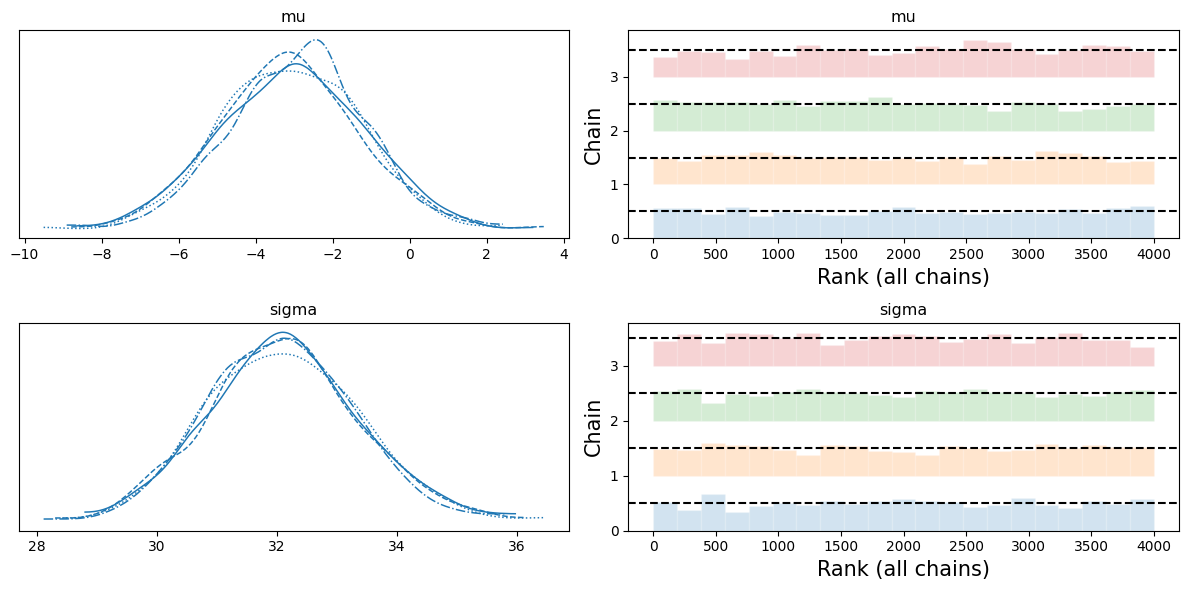

In [194]:
fig, axes = plt.subplots(2,2, figsize=(12,6))
az.plot_trace(inf_data_model1, kind="rank_bars", axes=axes)
fig.tight_layout()

Rank plot of the posterior samples from the model with Gumbel likelihood.

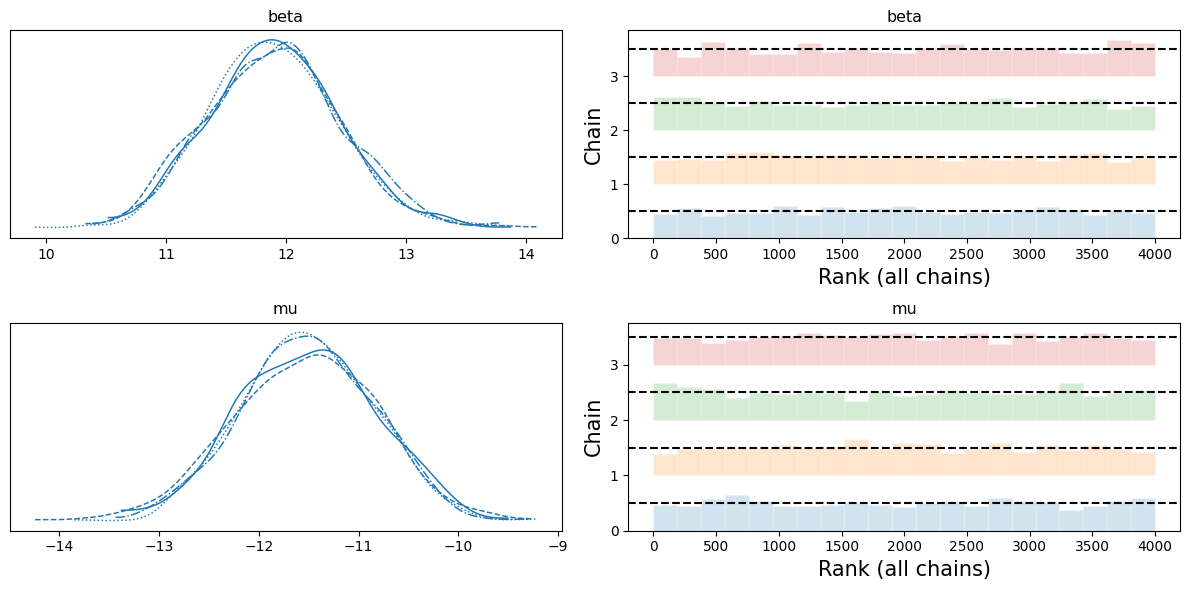

In [195]:
fig, axes = plt.subplots(2,2, figsize=(12,6))
az.plot_trace(inf_data_model2, kind="rank_bars", axes=axes)
fig.tight_layout()

For both models the rank plots, look fairly uniform 👌

## Posterior Plots

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

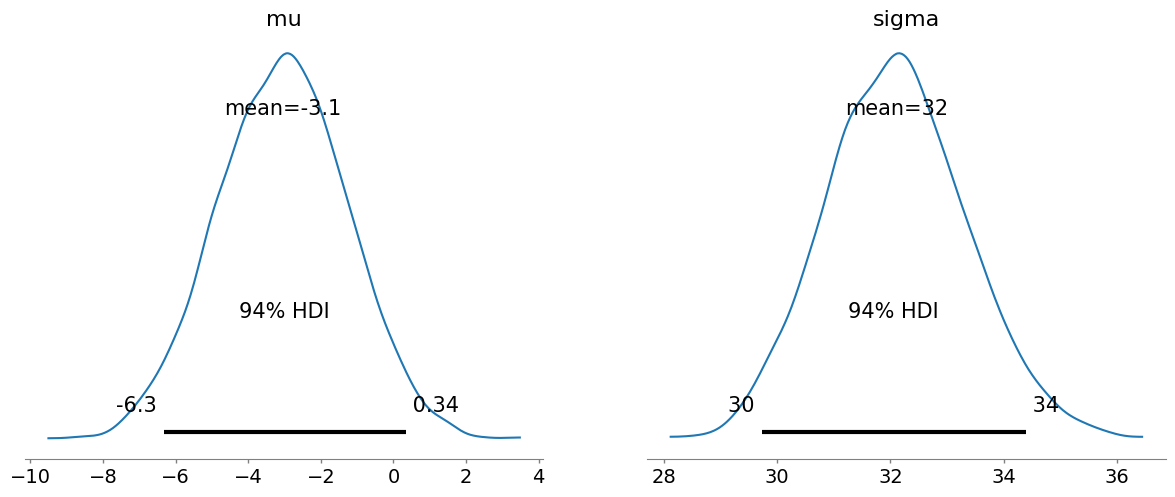

In [196]:
az.plot_posterior(inf_data_model1, var_names=['mu', 'sigma'])

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

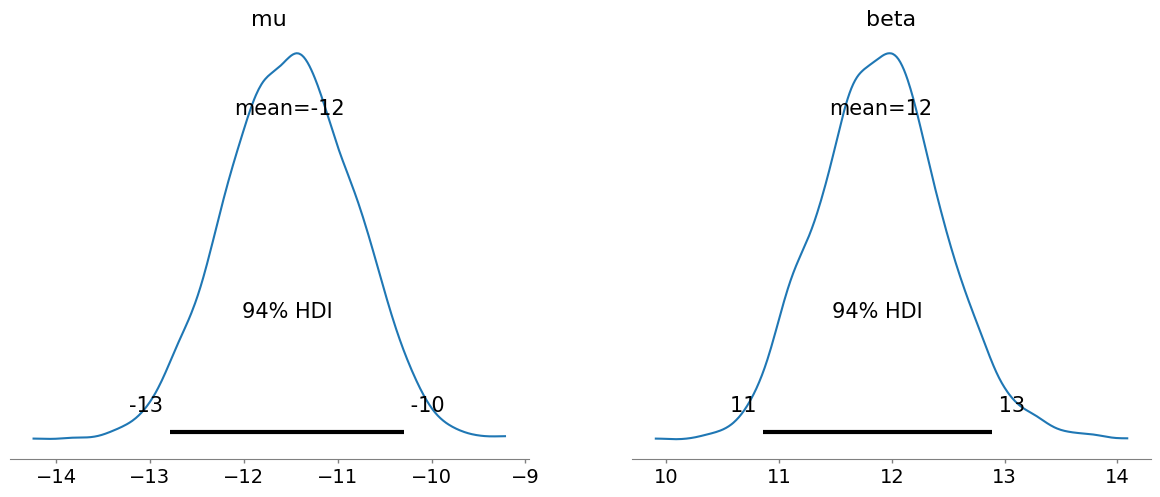

In [197]:
az.plot_posterior(inf_data_model2, var_names=['mu', 'beta'])

## Save Models

In [201]:
az.to_json(inf_data_model1, "../models/normal_data.json")

'../models/normal_data.json'

In [202]:
az.to_json(inf_data_model2, "../models/gumbel_data.json")

'../models/gumbel_data.json'